# Airline On-Time Performance
## by Hani Salah

## Investigation Overview

This presentation is intended to visually describe the main findings of USA Airline On-Time Performance.

## Dataset Overview

1. This data consists of flight arrival and departure details for all commercial flights within the USA, from October 1987 to April 2008. This is a large dataset: there are **<font color=red>nearly 120 million records</font>** in total, and takes up 1.6 gigabytes of space compressed and 12 gigabytes when uncompressed.  
2. Should all data be examined, tools other than **<font color=red>pandas</font>** will be required (e.g. **<font color=green>dask</font>**) to be able to wrangle *<font color=green>12GB</font>* worth of data. For the sake of simplicity **<font color=blue>years 1990, 1995, 2000, 2005 will be the only ones considered with 23.4 Million records.</font>**

In [1]:
# import all packages and set plots to be embedded inline
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

### Reading the data
1. Data is located in one zip archive. This zip archive contains multiple csv files (one for each year), each csv file is compressed with a .bz2 format.
2. Since it is the intention is to combine multiple reads of different csv files in one dataframe, a dictionary of datatypes is passed to the read_csv to avoid having different reads resulting in different datatypes. The dictionary is translated from an HTML file located in the same zip archive.
3. Encoding errors have been set to 'replace' to try to successfully read all files with UTF-8 encoding and if there is an error, the encoding is replaced inline according to the docs.

In [2]:
zf = zipfile.ZipFile('Data/DataExpo2009.Zip')
years=['1990','1995','2000','2005']
dtypes={'Year':np.int16, 'Month':np.int16, 'DayofMonth':np.int16, 'DayOfWeek':np.int16, 'DepTime':np.float64,
        'CRSDepTime':np.float64, 'ArrTime':np.float64, 'CRSArrTime':np.float64, 'UniqueCarrier':str,
        'FlightNum':str, 'TailNum':str, 'ActualElapsedTime':np.float64, 'CRSElapsedTime':np.float64,
        'AirTime':np.float64, 'ArrDelay':np.float64, 'DepDelay':np.float64, 'Origin':str, 'Dest':str,
        'Distance':np.float64, 'TaxiIn':np.float64, 'TaxiOut':np.float64, 'Cancelled':bool,
        'CancellationCode':str, 'Diverted':bool, 'CarrierDelay':np.float64, 'WeatherDelay':np.float64,
        'NASDelay':np.float64, 'SecurityDelay':np.float64, 'LateAircraftDelay':np.float64}

files = [file for file in zipfile.ZipFile.namelist(zf) if str(file)[-12:-8] in years]
df = pd.concat([pd.read_csv(zf.open(file),compression='bz2',encoding_errors='replace',dtype=dtypes) for file in files],
              ignore_index=True)
print('DataFrame Shape: ',df.shape)
df.head()

DataFrame Shape:  (23421971, 29)


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1990,1,3,3,1707.0,1630.0,1755.0,1723.0,US,29,...,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN
1,1990,1,4,4,1706.0,1630.0,1807.0,1723.0,US,29,...,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN
2,1990,1,5,5,1629.0,1630.0,1715.0,1723.0,US,29,...,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN
3,1990,1,6,6,1633.0,1630.0,1718.0,1723.0,US,29,...,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN
4,1990,1,8,1,1630.0,1630.0,1726.0,1723.0,US,29,...,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN


In [3]:
df.isnull().sum()

Year                        0
Month                       0
DayofMonth                  0
DayOfWeek                   0
DepTime                465583
CRSDepTime                  0
ArrTime                520311
CRSArrTime                  0
UniqueCarrier               0
FlightNum                   0
TailNum               5270893
ActualElapsedTime      520311
CRSElapsedTime           3518
AirTime               5670744
ArrDelay               520311
DepDelay               465583
Origin                      0
Dest                        0
Distance                99424
TaxiIn                5270893
TaxiOut               5270893
Cancelled                   0
CancellationCode     23288240
Diverted                    0
CarrierDelay         16281375
WeatherDelay         16281375
NASDelay             16281375
SecurityDelay        16281375
LateAircraftDelay    16281375
dtype: int64

### Observations for Cleaning
1. ***CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay***: There are 16.3 Million Null entries in each feature. These fields shouldn't be used since this number of Nulls is huge (70% of records) and as such inference based on these fields will not be accurate.  
2. ***CancellationCode*** is the same as above with 23.3 Million Nulls (almost 100% of records).
3. ***TaxiIn, TaxiOut***: Although Nulls are much less at 5.3 Million Null entries (20% of records), it is still a huge portion, and as such analysis made on these features can be severly biased.
4. ***AirTime***: Same as ***TaxiIn, TaxiOut***
5. ***TailNum***: Same as ***TaxiIn, TaxiOut***
6. ***DepTime and DepDelay*** have same number of Nulls (0.46 Million). While one can be used to infer the other, the abcense of both of them make it impossible to fill the data. We will drop those rows. It should be however understood that removing those rows will probably result in having the boolean fields ***Cancelled and Diverted*** to have False value in all remaining records.
7. ***ArrTime and ArrDelay***: Same as ***DepTime and DepDelay***
8. ***ActualElapsedTime***: Nulls are the same as ***ArrDelay***, and as such it is expected that Nulls will be removed once ***ArrDelay*** Nulls are removed.
9. ***CRSElapsedTime***: Nulls can be inferred from CRSArrTime and CRSDepTime.
10. ***DepTime, CRSDepTime, ArrTime, CRSArrTime***: Data is written in funny way. It is in the form of hhmm and interpreted as a float. This needs to be corrected to a logical representation (e.g. float representing hh.mm.)

In [4]:
drop_col=['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationCode',
         'TaxiIn','TaxiOut', 'AirTime', 'TailNum']
time_cols=['DepTime','CRSDepTime','ArrTime','CRSArrTime']
print('Before dropping, let us check the values for Cancelled and Diverted fields\n')
print(df['Cancelled'].value_counts(),'\n')
print(df['Diverted'].value_counts(),'\n')
for col in time_cols:
    df[col]=df[col].astype(float)//100 + (df[col].astype(float)%100)/60
df.drop(columns=drop_col, inplace=True)
df.dropna(subset=['DepTime'], inplace=True)
df.dropna(subset=['ArrTime'], inplace=True)
df['CRSElapsedTime'].fillna((df['CRSArrTime']-df['CRSDepTime'])*60, inplace=True)
print('Let us check again the values for Cancelled and Diverted fields after dropping the rows\n')
print(df['Cancelled'].value_counts(),'\n')
print(df['Diverted'].value_counts(),'\n')
print('Indeed, both columns are now all False and as such will not help in any further analysis\nLet us drop them\n')
df.drop(columns=['Cancelled','Diverted'], inplace=True)
df.isnull().sum()

Before dropping, let us check the values for Cancelled and Diverted fields

False    22956388
True       465583
Name: Cancelled, dtype: int64 

False    23367243
True        54728
Name: Diverted, dtype: int64 

Let us check again the values for Cancelled and Diverted fields after dropping the rows

False    22901660
Name: Cancelled, dtype: int64 

False    22901660
Name: Diverted, dtype: int64 

Indeed, both columns are now all False and as such will not help in any further analysis
Let us drop them



Year                     0
Month                    0
DayofMonth               0
DayOfWeek                0
DepTime                  0
CRSDepTime               0
ArrTime                  0
CRSArrTime               0
UniqueCarrier            0
FlightNum                0
ActualElapsedTime        0
CRSElapsedTime           0
ArrDelay                 0
DepDelay                 0
Origin                   0
Dest                     0
Distance             97852
dtype: int64

### Further Cleaning  
What about those Nulls in the **Distance** field?

In [5]:
distance_df = df[df['Distance'].isnull()].groupby(['Origin','Dest']).size().reset_index().rename(columns={0:'DistNulls'})
print('Null Distance shape: ',distance_df.shape)
distance_df.head()

Null Distance shape:  (239, 3)


,Origin,Dest,DistNulls
0,ABQ,DAL,212
1,ABQ,DFW,661
2,AMA,DAL,370
3,AMA,DFW,448
4,ATL,DFW,903


Are these **Origin/Dest** combinations filled somewhere else in our data?

In [6]:
airport_comb = distance_df.set_index(['Origin','Dest']).index.tolist()
all_airport_comb = pd.MultiIndex.from_frame(df[["Origin","Dest"]])
airport_comb_unique = df[all_airport_comb.isin(airport_comb)].groupby(['Origin','Dest'])['Distance'].nunique()
print('Is there a maximum of one unique distance for each Origin/Dest?: ', (airport_comb_unique>1).all()==False)
print('How many Origin/Dest combinations can be filled out of 239?: ',airport_comb_unique.sum())
print('Ok, Let us fill them')
df['Distance']=df.groupby(['Origin','Dest'])['Distance'].transform(lambda x:x.fillna(x.max()))
print('Is there still a maximum of one unique distance for each Origin/Dest?: ', (airport_comb_unique>1).all()==False)

Is there a maximum of one unique distance for each Origin/Dest?:  True
How many Origin/Dest combinations can be filled out of 239?:  239
Ok, Let us fill them
Is there still a maximum of one unique distance for each Origin/Dest?:  True


**<font color=blue>Finally now we have a clean data frame with no Nulls</font>**

In [7]:
print('DataFrame Shape: ',df.shape)
df.isnull().sum()

DataFrame Shape:  (22901660, 17)


Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
ActualElapsedTime    0
CRSElapsedTime       0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
dtype: int64

Now we have number of columns that really truly represent categorical data (they are shown below).  
So let's convert them to category data type. The month, day parts are of course ordinal, while others are nominal.   
However, for ease of comparing and exploring, we will just order each categorical field (ascending) and convert it to ordered category datatype.  
Furthermore, origin and dest both represent airport names, as such they should be the same category data type. As such, we will create a union of the two lists, and this union will be the datatype.

In [8]:
cat_vars= ['Year','Month','DayofMonth','DayOfWeek','UniqueCarrier','FlightNum','Origin','Dest']
org_airport=set(df['Origin'].unique())
dst_airport=set(df['Dest'].unique())
airports=org_airport.union(dst_airport)
for var in cat_vars:
    if var=='Origin' or var=='Dest':
        cat_var_list = (list(airports)).sort()
    else:
        cat_var_list = df[var].unique().tolist().sort()
    cat_var_type = pd.api.types.CategoricalDtype(ordered=True, categories=cat_var_list)
    df[var]=df[var].astype(cat_var_type)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22901660 entries, 0 to 23421970
Data columns (total 17 columns):
 #   Column             Dtype   
---  ------             -----   
 0   Year               category
 1   Month              category
 2   DayofMonth         category
 3   DayOfWeek          category
 4   DepTime            float64 
 5   CRSDepTime         float64 
 6   ArrTime            float64 
 7   CRSArrTime         float64 
 8   UniqueCarrier      category
 9   FlightNum          category
 10  ActualElapsedTime  float64 
 11  CRSElapsedTime     float64 
 12  ArrDelay           float64 
 13  DepDelay           float64 
 14  Origin             category
 15  Dest               category
 16  Distance           float64 
dtypes: category(8), float64(9)
memory usage: 1.9 GB


### What is the structure of your dataset?

After cleaning and wrangling the data as explained above, the structure of the dataset is **22,901,660 records** with **17 fields**. This data shows the flight details for commercial flights in USA for years 1990, 1995, 2000, 2005.

### What is/are the main feature(s) of interest in your dataset?

The main features of interest are:  
1. Delays (represented by Arrival delays and Departure Delays).
2. Most popular flight times (represented by DepTime and ArrTime).
3. How busy are the airports (represented by Origin and Destination).
4. Carrier(s) that have the most flights

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

1. Are delays attributed to certain time of year / month? (using Year, Month, DayofMonth, Dayof Week)
2. Are delays attributed to certain carrier(s)? (using UniqueCarrier)
3. Are delays attributed to certain airport(s)? (using Origin, Dest)

## Univariate Exploration

In this section, we will investigate distributions of individual variables.

### **Departure Delay** Distribution
1. The distribution of delays is around the 'No significant delay point'.
2. The main spread of the departure delays is from -20 minutes (early departures) to 40 minutes.

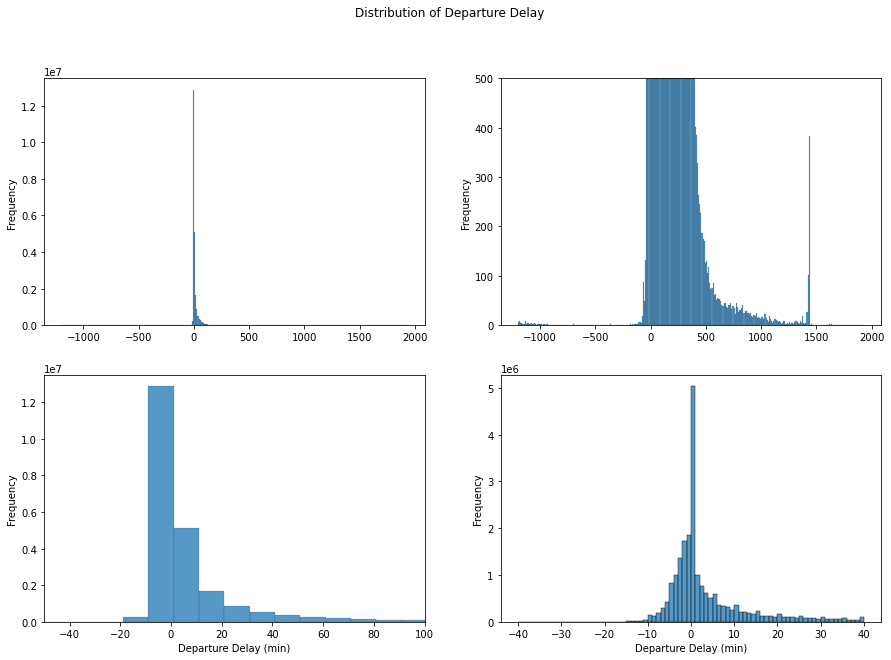

In [9]:
plt.figure(figsize=(15,10))
plt.suptitle('Distribution of Departure Delay')
bins=np.arange(df['DepDelay'].min(),df['DepDelay'].max()+10,10)
bins_zoomed=np.arange(-40,40+1,1)

plt.subplot(2,2,1)
sb.histplot(data=df, x='DepDelay', bins=bins)
plt.ylabel('Frequency')
plt.xlabel('')

plt.subplot(2,2,2)
sb.histplot(data=df, x='DepDelay', bins=bins)
plt.ylim(0,500)
plt.ylabel('Frequency')
plt.xlabel('')

plt.subplot(2,2,3)
sb.histplot(data=df, x='DepDelay', bins=bins)
plt.xlim(-50,100)
plt.ylabel('Frequency')
plt.xlabel('Departure Delay (min)')

plt.subplot(2,2,4)
sb.histplot(data=df, x='DepDelay', bins=bins_zoomed)
plt.ylabel('Frequency')
plt.xlabel('Departure Delay (min)');

### **Arrival Delay** Distribution:
1. The distribution of delays is around the 'No significant delay point'.
2. The main spread of the arrival delays is from -20 minutes (early arrivals) to 60 minutes.

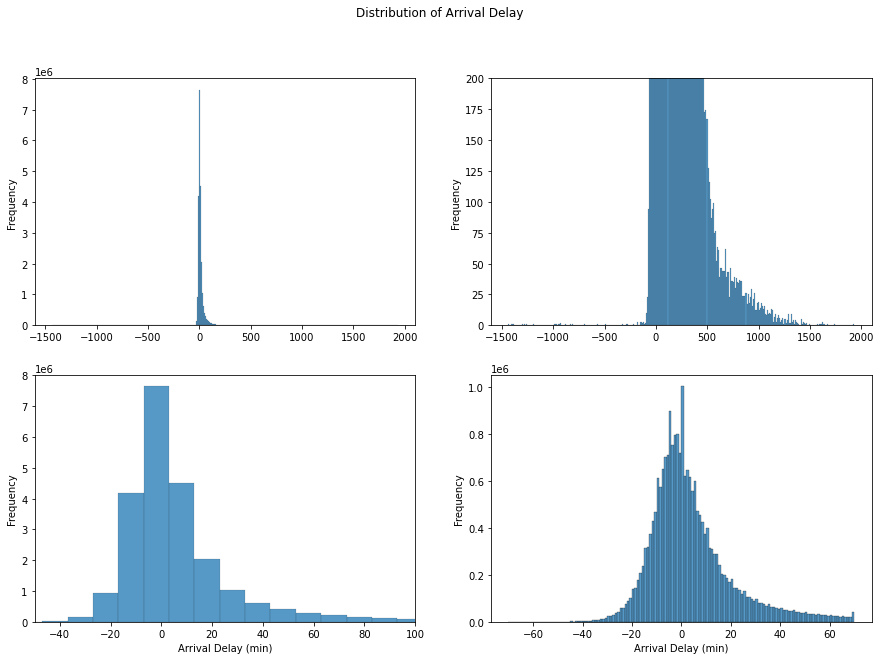

In [10]:
plt.figure(figsize=(15,10))
plt.suptitle('Distribution of Arrival Delay')
bins=np.arange(df['ArrDelay'].min(),df['ArrDelay'].max()+10,10)
bins_zoomed=np.arange(-70,70+1,1)

plt.subplot(2,2,1)
sb.histplot(data=df, x='ArrDelay', bins=bins)
plt.ylabel('Frequency')
plt.xlabel('')

plt.subplot(2,2,2)
sb.histplot(data=df, x='ArrDelay', bins=bins)
plt.ylim(0,200)
plt.ylabel('Frequency')
plt.xlabel('')

plt.subplot(2,2,3)
sb.histplot(data=df, x='ArrDelay', bins=bins)
plt.xlim(-50,100)
plt.ylabel('Frequency')
plt.xlabel('Arrival Delay (min)')

plt.subplot(2,2,4)
sb.histplot(data=df, x='ArrDelay', bins=bins_zoomed)
plt.ylabel('Frequency')
plt.xlabel('Arrival Delay (min)');

### Flight Times Distribution:
The distribution of flights timing (both Departure and Arrival) doesnot reveal much except that the US skies is busy starting 6:00 up to 20:00 ~ 22:00

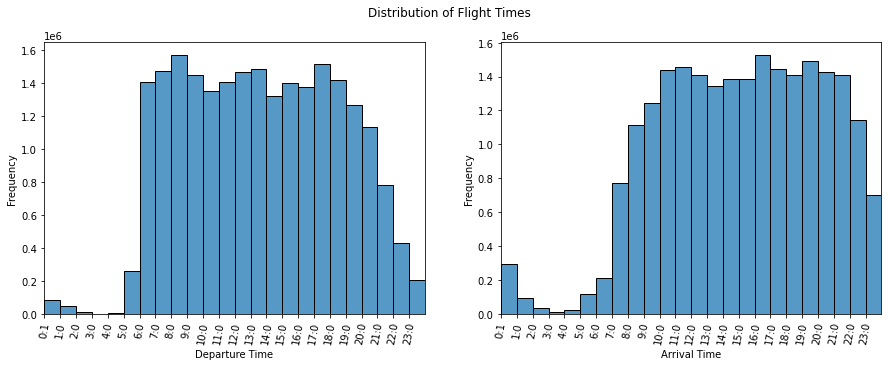

In [11]:
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of Flight Times')

plt.subplot(1,2,1)
bins=np.arange(df['DepTime'].min(),df['DepTime'].max()+1,1)
sb.histplot(data=df, x='DepTime', bins=bins)
plt.ylabel('Frequency')
labels= np.char.add( (bins//1).astype(int).astype(str), np.char.add(':', ((bins%1)*60).astype(int).astype(str) )).tolist()
plt.xticks(bins, labels, rotation=80)
plt.xlim(0,24)
plt.xlabel('Departure Time')

plt.subplot(1,2,2)
bins=np.arange(df['ArrTime'].min(),df['ArrTime'].max()+1,1)
sb.histplot(data=df, x='ArrTime', bins=bins)
plt.ylabel('Frequency')
labels= np.char.add( (bins//1).astype(int).astype(str), np.char.add(':', ((bins%1)*60).astype(int).astype(str) )).tolist()
plt.xticks(bins, labels, rotation=80)
plt.xlim(0,24)
plt.xlabel('Arrival Time');

### Carrier Distribution:
We have 7 Carriers that each operated more than 1.5 million flights. We can call those the big players and have them further analyzed in bi/multi-variate analysis.

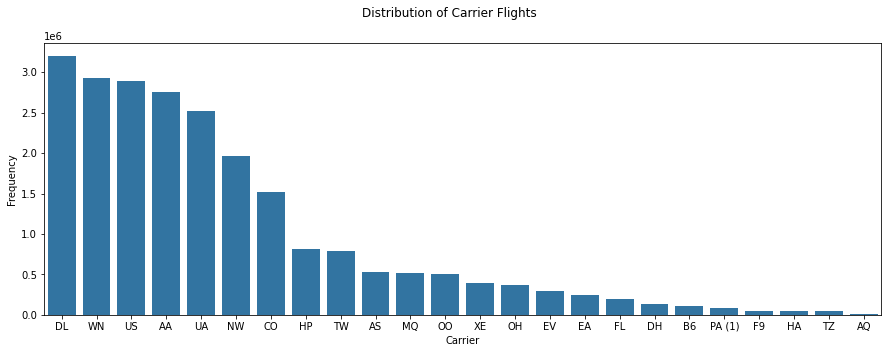

In [12]:
base_color = sb.color_palette()[0]
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of Carrier Flights')
sb.countplot(data=df, x='UniqueCarrier', color=base_color, order=df['UniqueCarrier'].value_counts().index)
plt.ylabel('Frequency')
plt.xlabel('Carrier');

### Busily Airports:

There are 11 airports that have more than 1 million flights each as shown in the zoomed view below

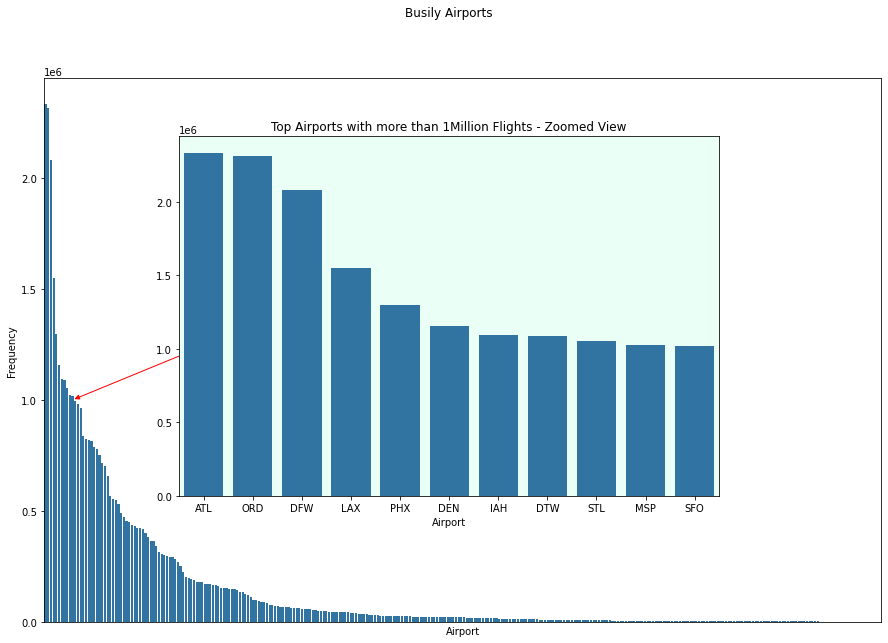

In [13]:
base_color = sb.color_palette()[0]
flights_airports=df.melt(value_vars=['Origin','Dest'],var_name='Direction',value_name='Airport')
plt.figure(figsize=(15,10))
plt.suptitle('Busily Airports')

sb.countplot(data=flights_airports, x='Airport',order=flights_airports['Airport'].value_counts().index, color=base_color)
plt.ylabel('Frequency')
plt.xticks([])

zoom_df = flights_airports[flights_airports.groupby('Airport')['Airport'].transform('size')>=int(1e6)]
plt.annotate("", xy=(10, 1e6), xytext=(50, 1.2e6),arrowprops=dict(arrowstyle="-|>",color='r',ls='-'))
ax=plt.axes([0.25,0.3,0.5,0.5], facecolor='#eafff5')
zoom= sb.countplot(data=zoom_df, x='Airport', order=zoom_df['Airport'].value_counts().index, color=base_color, ax=ax)
zoom.set_title('Top Airports with more than 1Million Flights - Zoomed View')
zoom.set(ylabel=None);

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

1. Transformations were not needed.
2. There is no unusual points.
3. Departure Delays is mainly centered around the zero point. Departure Delays for all reasonable considerations are within 40 minutes which should be acceptable.
4. Arrival Delays is also mainly centered around the zero point. Arrival Delays for all reasonable considerations are within 60 minutes which should be acceptable.
5. Distribution of most popular flight times didn't tell us much. US skies is fairly busy.
6. There are 11 airports that each had administered more than 1 Million flights over the selected years. There is a slightly larger subset that range from 0.5 Million to a Million. There is a huge list of airports that have served less than 0.5 Million flights.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

There is nothing unusual other than that for the selected dataset, when the dataset was being made tidy and clean, we had to drop all columns related to cancellations or diversions. The reasoning for that is explained above in the cleaning part.

## Bivariate Exploration

In this section, we will investigate relationships between pairs of variables.

### Yearly and Monthly Departure Delay Distribution

1. We focus on the area of interest observed in the univariate distribution of (-40 to 40 minutes).
2. The Departure Delay = 0 tend to decrease over the years from 1990 to 2000 and then start to increase again in 2005. It could be assumed that "strictness" to timing has been decreasing over the years until some threshold occured that activated more rigorous controls to attain the departure delay at 0.  
3. The spread of Departure Delay in the negative direction is increasing over the years. This can mean that flight travels are becoming more popular over the years and airports are gaining experiences that they even make flights occur earlier than their scheduled time.

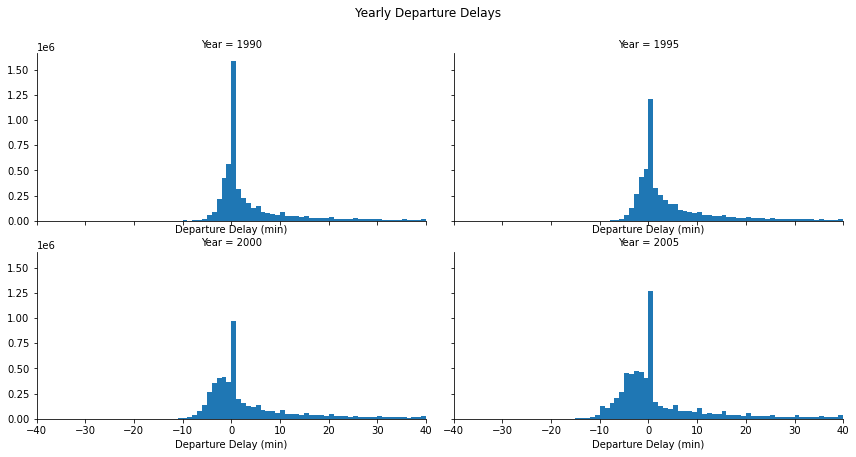

In [14]:
bins_zoomed=np.arange(-40,40+1,1)
g= sb.FacetGrid(data= df, col= 'Year', col_wrap= 2, aspect=2, xlim=(-40,40))
g.map(plt.hist, 'DepDelay', bins=bins_zoomed)
g.fig.suptitle('Yearly Departure Delays',y=1.05)
g.set(xlabel='Departure Delay (min)');

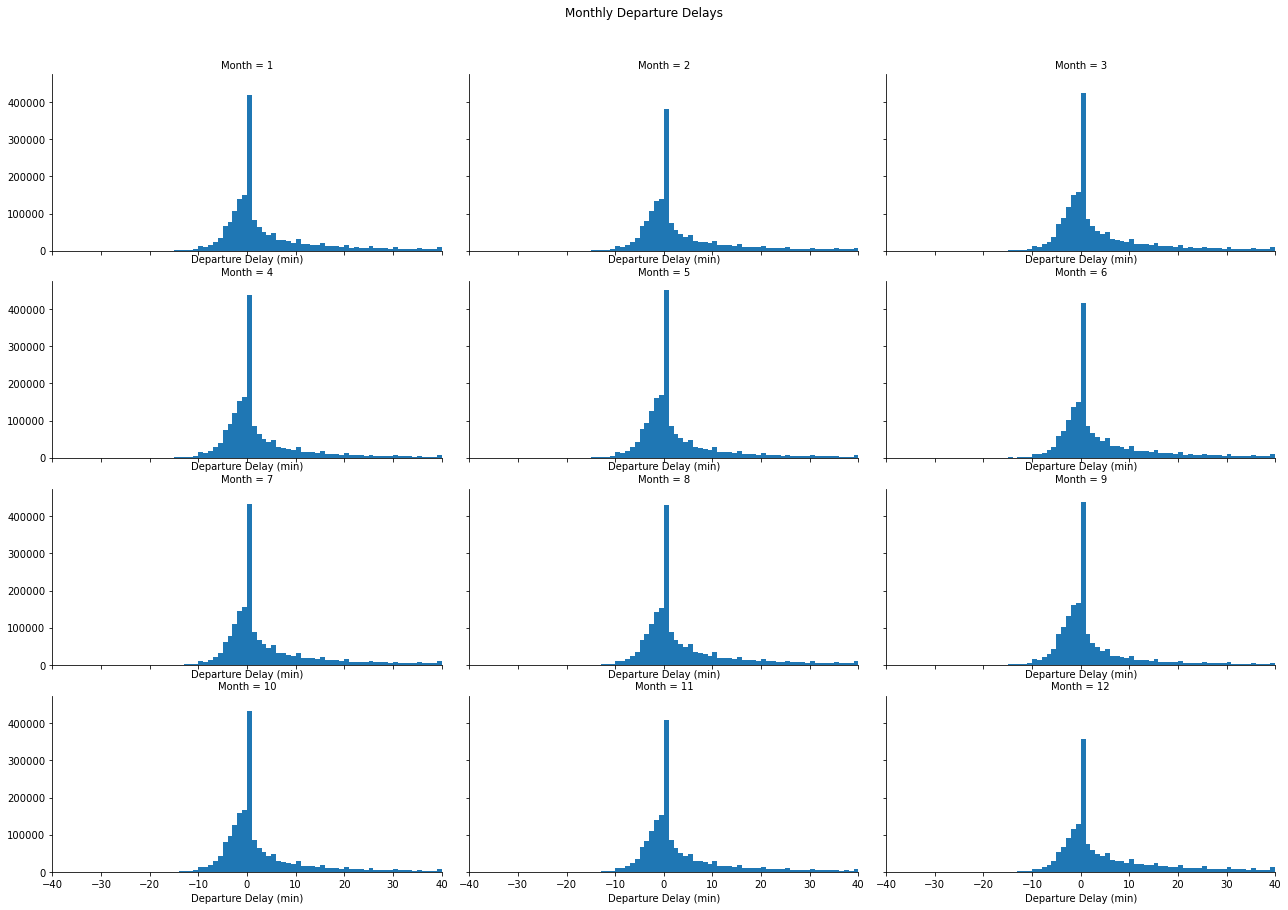

In [15]:
bins_zoomed=np.arange(-40,40+1,1)
g= sb.FacetGrid(data= df, col= 'Month', col_wrap= 3, aspect=2, xlim=(-40,40))
g.map(plt.hist, 'DepDelay', bins=bins_zoomed)
g.fig.suptitle('Monthly Departure Delays',y=1.05)
g.set(xlabel='Departure Delay (min)');

### Yearly and Monthly Arrival Delay Distribution

1. We focus on the area of interest observed in the univariate distribution of (-70 to 70 minutes).
2. The Monthly distribution doesn't even shed more insight, may be except that it is driven by the same shape of the most recent years (2000, 2005).

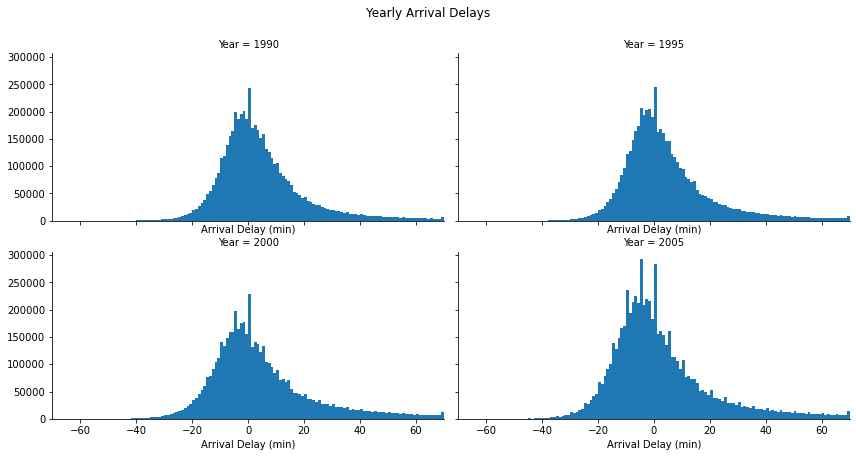

In [16]:
bins_zoomed=np.arange(-70,70+1,1)
g= sb.FacetGrid(data= df, col= 'Year', col_wrap= 2, aspect=2, xlim=(-70,70))
g.map(plt.hist, 'ArrDelay', bins=bins_zoomed)
g.fig.suptitle('Yearly Arrival Delays',y=1.05)
g.set(xlabel='Arrival Delay (min)');

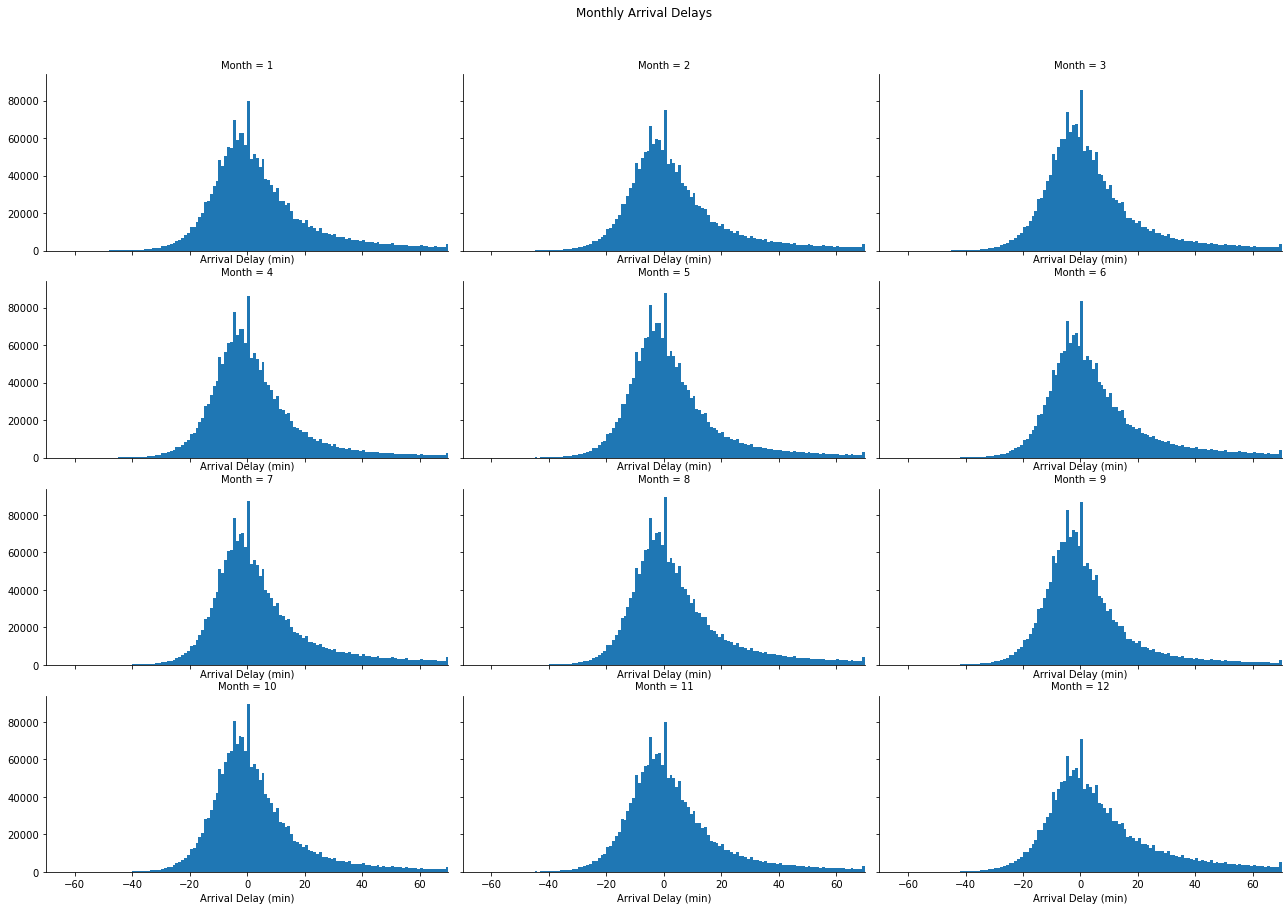

In [17]:
bins_zoomed=np.arange(-70,70+1,1)
g= sb.FacetGrid(data= df, col= 'Month', col_wrap= 3, aspect=2, xlim=(-70,70))
g.map(plt.hist, 'ArrDelay', bins=bins_zoomed)
g.fig.suptitle('Monthly Arrival Delays',y=1.05)
g.set(xlabel='Arrival Delay (min)');

### Arrival Delay vs. Departure Delay:
Aside from the outliers, we can see a strong positive relation between the two variables. We can almost see the regression line drawn by overplotting scatter points.

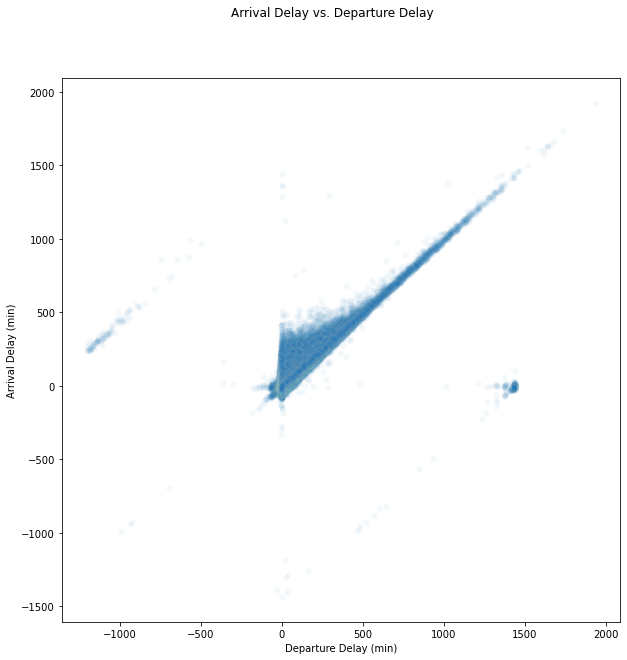

In [18]:
plt.figure(figsize=(10,10))
plt.suptitle('Arrival Delay vs. Departure Delay')
sb.scatterplot(data=df, x='DepDelay', y='ArrDelay', alpha= 1/20)
plt.xlabel('Departure Delay (min)')
plt.ylabel('Arrival Delay (min)');

### Carrier Delay Percentage:

| Carrier | Rank by <br> Flights Count | Rank by <br> Delay Percentage |
|:-:|:-:|:-:|
| DL | 1 | 1 |
| WN | 2 | 12 |
| US | 3 | 4 |
| AA | 4 | 7 |
| UA | 5 | 2 |
| NW | 6 | 13 |
| CO | 7 | 9 |

#### Observations:
1. DL Airlines ranked top in both classes. This could be that typical behaviour of a giant relying on heritage, reputation and not seeing the slippery road ahead.
2. WN Airlines has a very interesting performance. While ranking second in number of flights, they managed to rank themselves twelveth in percent delays. Thumbs Up!
3. UA Airlines is on the other end of the spectrum. They rank fifth in top operators (average big player), but they ranked second in percent delays. These guys can need some consultations to their operations.

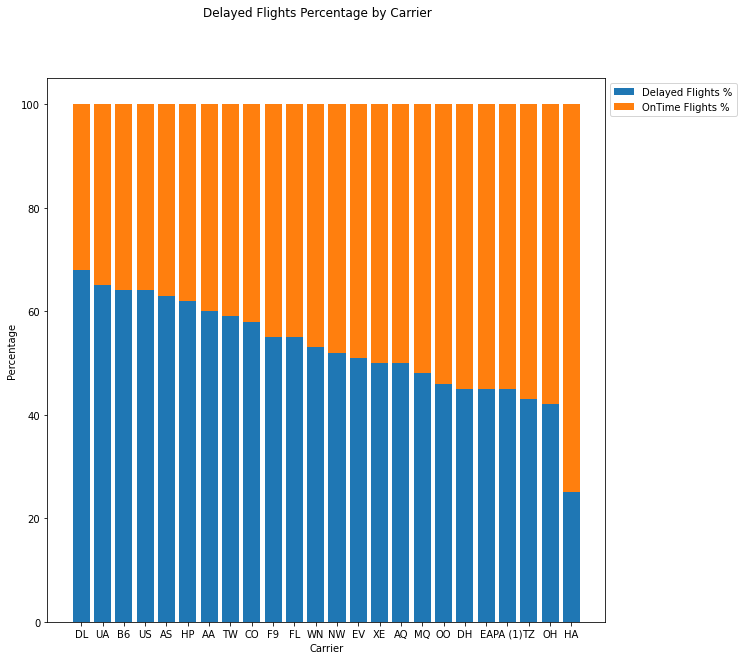

In [19]:
x1=df.groupby('UniqueCarrier').size().reset_index().rename(columns={0:'Total_Flights'})
x2=df[(df['DepDelay']>0)|(df['ArrDelay']>0)].groupby('UniqueCarrier').size().reset_index().rename(columns={0:'Delayed'})
df_carrier_delay=x1.merge(x2,on='UniqueCarrier')
df_carrier_delay['Delay_Percent']= 100* df_carrier_delay['Delayed']/df_carrier_delay['Total_Flights']
df_carrier_delay['Delay_Percent']=df_carrier_delay['Delay_Percent'].astype(int)
df_carrier_delay['OnTime_Percent']= 100-df_carrier_delay['Delay_Percent']
df_carrier_delay.sort_values(by='Delay_Percent',ascending=False, inplace=True)
df_carrier_delay.head(5)

plt.figure(figsize=(10,10))
plt.suptitle('Delayed Flights Percentage by Carrier')
plt.bar(x=df_carrier_delay['UniqueCarrier'],height=df_carrier_delay['Delay_Percent'],label='Delayed Flights %')
plt.bar(x=df_carrier_delay['UniqueCarrier'],height=df_carrier_delay['OnTime_Percent'], 
        bottom=df_carrier_delay['Delay_Percent'], label='OnTime Flights %')
plt.xlabel('Carrier')
plt.ylabel('Percentage')
plt.legend(bbox_to_anchor=(1,1));

### Airports' Delays:

1. We can see that there are three airports that are considered busily (more than 1 million flights) both based on inbound and inbound/outbound combinations. Interestingly these three airports are absent from the top delaying airports (with average delays of more than 15 minutes). You should be lucky to have your flight departing from ATL, ORD or DFW airports.
2. We also notice that there are 4 airports with a negative average delay. These airports may have spectacular operation or they are of small size with small number of flights.

This point onwards, we will examine only departure delays. Arrival delays in context of this data is a measure of how long the flight took beyond its schedule. As such, arrival operation optimization such as availability of shuttle busses, luggage belts..etc cannot be explained by this dataset. In this regards, we can only attibute an airport to a departure delay. Airports with better operations (more checkin counters, faster security scans..etc) will tend to minimize departure delays. This is further evident statistically by the strong corellation between departure delay and arrival delay decpicted earlier.

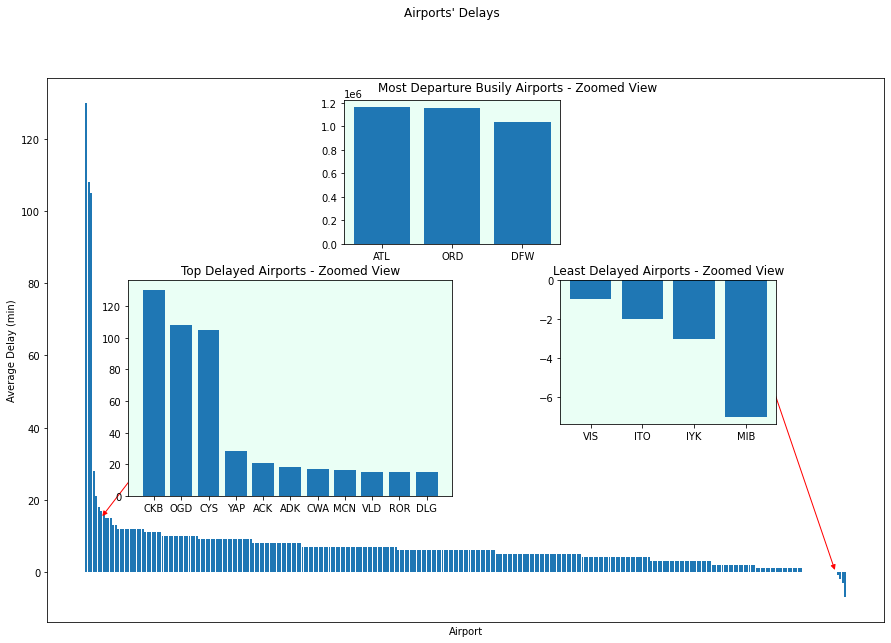

In [20]:
Airport_Delays = (df.groupby(['Origin'])['DepDelay'].mean()).reset_index().rename(columns={'DepDelay':'Avg_Delay'})
Airport_Delays['Avg_Delay']=Airport_Delays['Avg_Delay'].astype(int)
Airport_Delays.sort_values(by='Avg_Delay', ascending=False, inplace=True)

plt.figure(figsize=(15,10))
plt.suptitle('Airports\' Delays')

plt.bar(x=Airport_Delays['Origin'], height=Airport_Delays['Avg_Delay'])
plt.ylabel('Average Delay (min)')
plt.xlabel('Airport')
plt.xticks([]);

zoom_df = Airport_Delays[Airport_Delays['Avg_Delay']>=15]
zoom_df2 = Airport_Delays[Airport_Delays['Avg_Delay']<0]
zoom_df3 = flights_airports[flights_airports['Direction']=='Origin'].value_counts().reset_index().rename(columns={0:'Num'})
zoom_df3 = zoom_df3[zoom_df3['Num']>=1e6]
                    
plt.annotate("", xy=(6, 15), xytext=(40, 45),arrowprops=dict(arrowstyle="-|>",color='r',ls='-'))
plt.annotate("", xy=(305, 0), xytext=(270, 70),arrowprops=dict(arrowstyle="-|>",color='r',ls='-'))
ax=plt.axes([0.2,0.3,0.3,0.3], facecolor='#eafff5')
ax.bar(x=zoom_df['Origin'],height=zoom_df['Avg_Delay'])
ax.set_title('Top Delayed Airports - Zoomed View')

ax2=plt.axes([0.6,0.4,0.2,0.2], facecolor='#eafff5')
ax2.bar(x=zoom_df2['Origin'],height=zoom_df2['Avg_Delay'])
ax2.set_title('Least Delayed Airports - Zoomed View')

ax3=plt.axes([0.4,0.65,0.2,0.2], facecolor='#eafff5')
ax3.bar(x=zoom_df3['Airport'], height=zoom_df3['Num'])
ax3.set_title('Most Departure Busily Airports - Zoomed View',x=0.8,y=1.02);

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

1. We couldn't observe a coronological relation with Departure or Arrival Delays. This is rather logical due to the limited and sparse nature of our dataset (1 year worth of data every 5 years).
2. There is a strong positive correlation between Arrival Delay and Departure Delay. In absence of other pointers, one would think that arrival delay is mainly driven by departure delay. However, we should not foreget that columns descibing the reasons for delays have been dropped in our cleaning step since they didn't contain enough data to evaluate.
3. We observed interesting relation between the carrier operating volume and their departure delays. Particularly for DL, WN, UA; where DL tend to be the jiant going down the slippery road, WN earn thumbs up for being a big player and having minimum delays, UA on the other hand may need consultation to strengthen its volume and minimize its delays.
4. The top operating airports (ATL, ORD, DFW) have spectacular operations to keep their departure delays less than 15 minutes.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

We are mainly focusing on the main features and as such visualizing the other features is not pursued. However such insight may bubble with multivariate exploration.

## Multivariate Exploration

Here we will create multivariate plots to investigate the dataset.

### Chronological Departure Delay Distribution

The graph further proves the spread of Departure Delay in the negative direction is increasing over time.

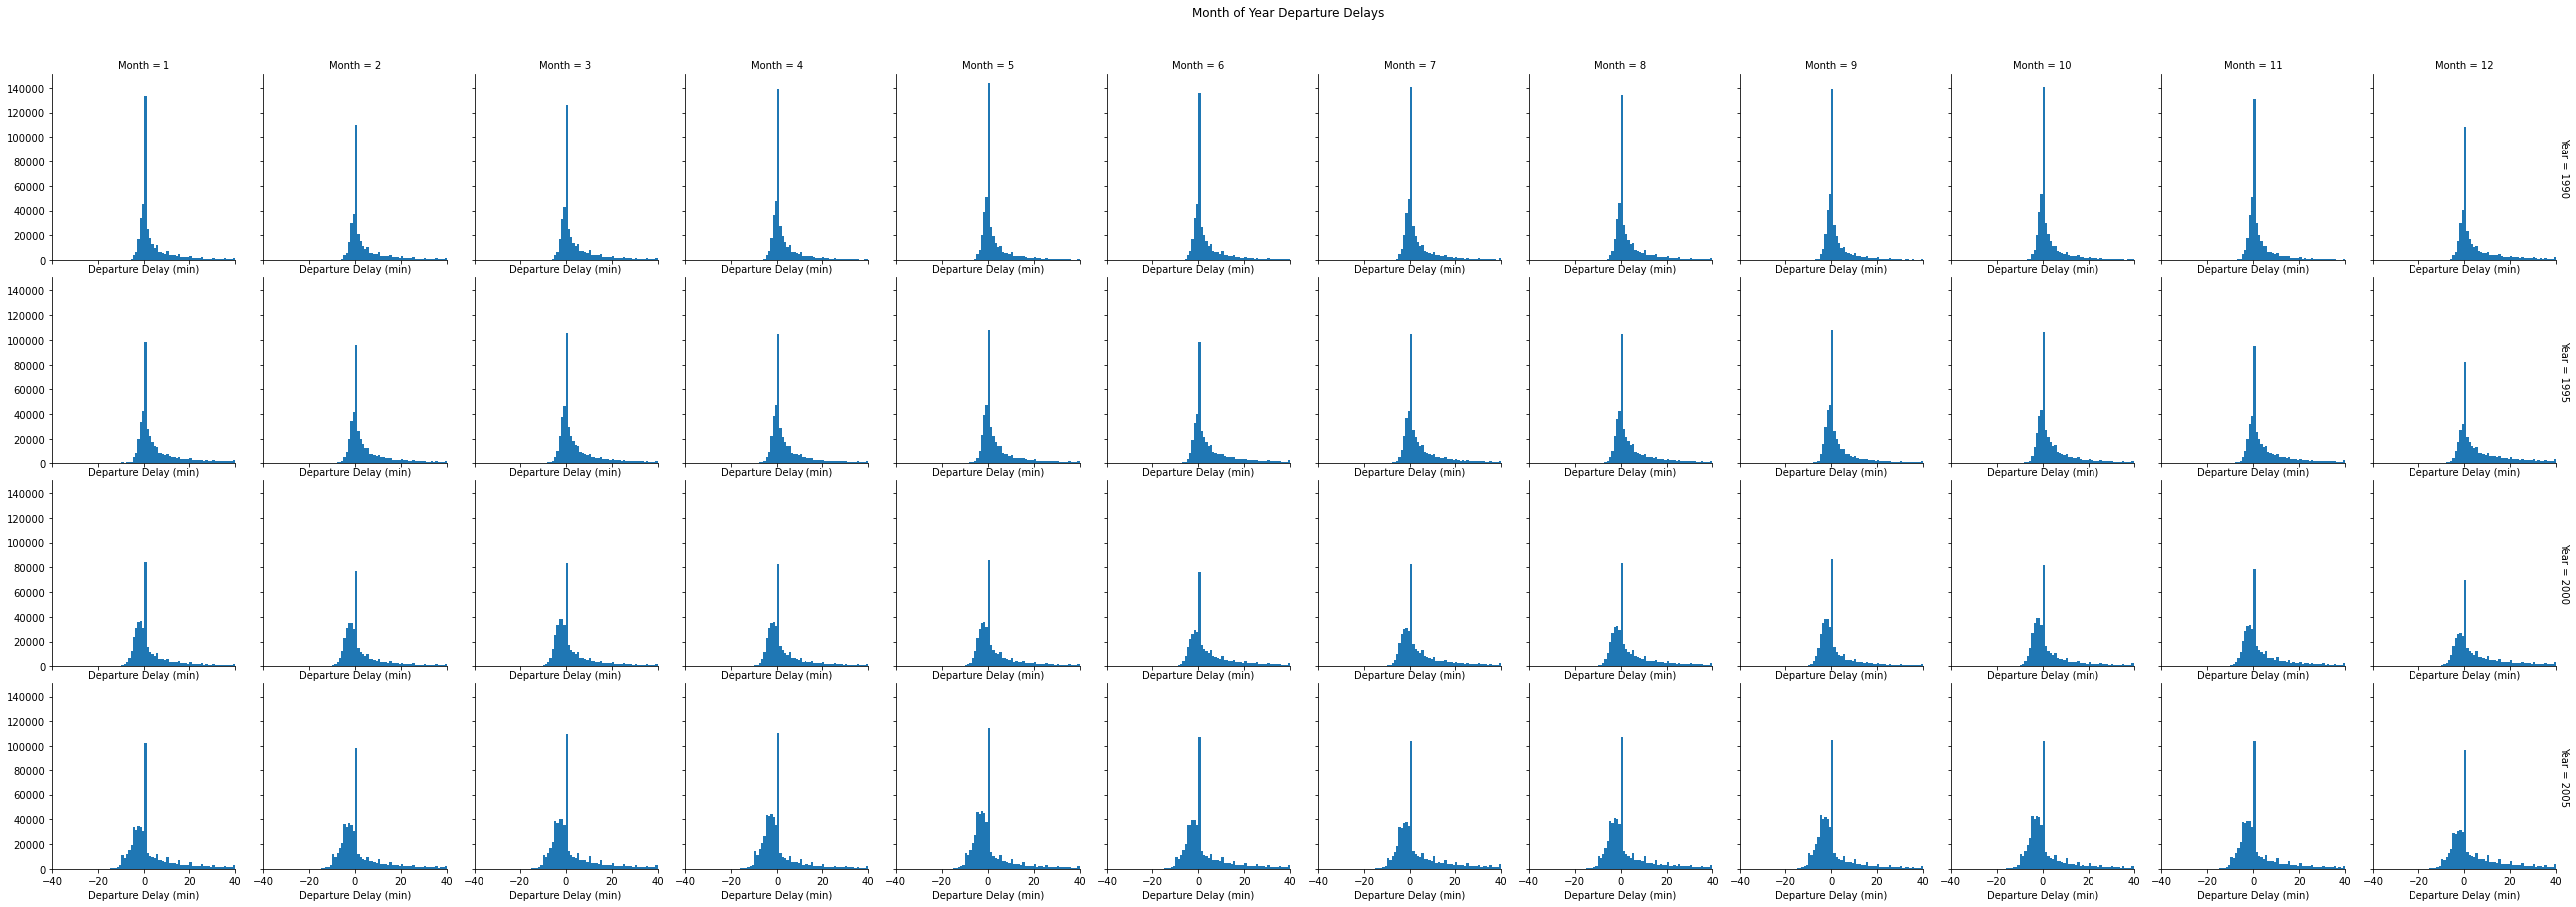

In [21]:
bins_zoomed=np.arange(-40,40+1,1)
g= sb.FacetGrid(data= df, col='Month', row= 'Year', xlim=(-40,40), margin_titles=True)
g.map(plt.hist, 'DepDelay', bins=bins_zoomed)
g.fig.suptitle('Month of Year Departure Delays',y=1.05)
g.set(xlabel='Departure Delay (min)');

### Where would you expect the worst delays:

The data shows that the average delays were highest for flights operated by the below airlines from the shown airports.  

|Airport|Air Line|Average Delay<br>(min)|
|:-----:|:------:|:--------------------:|
|CKB|OH|130|
|HOU|OH|79|
|CYS|OO|105|
|OGD|OO|108|
|GJT|AA|70|

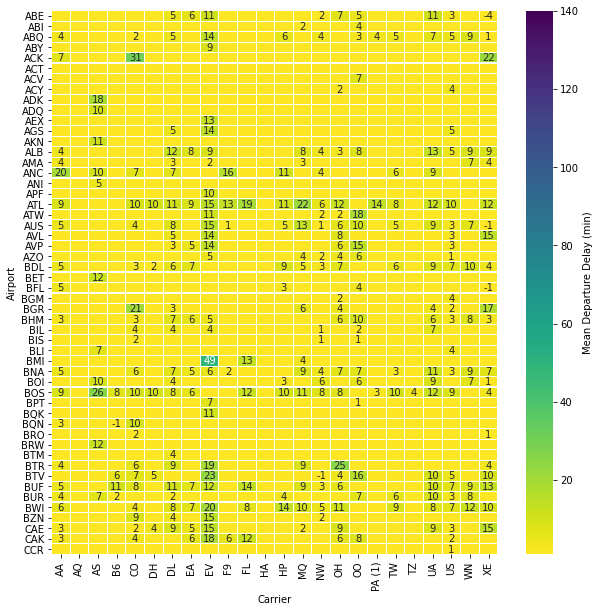

In [22]:
dep_delay_means = df.groupby(['UniqueCarrier', 'Origin']).mean()['DepDelay']
dep_delay_means = dep_delay_means.reset_index(name = 'DepDelay_Avg')
dep_delay_means['DepDelay_Avg'].fillna(-100,inplace=True)
dep_delay_means['DepDelay_Avg']=dep_delay_means['DepDelay_Avg'].astype(int)
dep_delay_means = dep_delay_means.pivot(index = 'Origin', columns = 'UniqueCarrier', values = 'DepDelay_Avg')
labels = dep_delay_means.copy()
for col in labels.columns:
    labels[col]=labels[col].astype(str)
    labels[col].replace('-100','',inplace=True)
    labels[col].replace('0','',inplace=True)

ddm_sliced, labels_sliced=[],[]
j=0
for i in range(6):
    ddm_sliced.append(dep_delay_means.iloc[j:j+52])
    labels_sliced.append(labels.iloc[j:j+52])
    j+=52

plt.figure(figsize=(10,10))
sb.heatmap(ddm_sliced[0], annot=labels_sliced[0], fmt='s', vmin=1, vmax=140, cmap='viridis_r', linewidth=0.1, 
           cbar_kws ={'label':'Mean Departure Delay (min)'})
plt.ylabel('Airport')
plt.xlabel('Carrier');

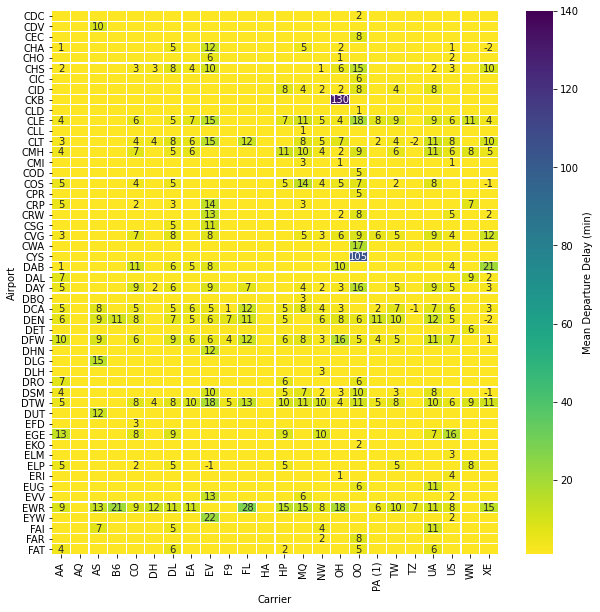

In [23]:
plt.figure(figsize=(10,10))
sb.heatmap(ddm_sliced[1], annot=labels_sliced[1], fmt='s', vmin=1, vmax=140, cmap='viridis_r', linewidth=0.1, 
           cbar_kws ={'label':'Mean Departure Delay (min)'})
plt.ylabel('Airport')
plt.xlabel('Carrier');

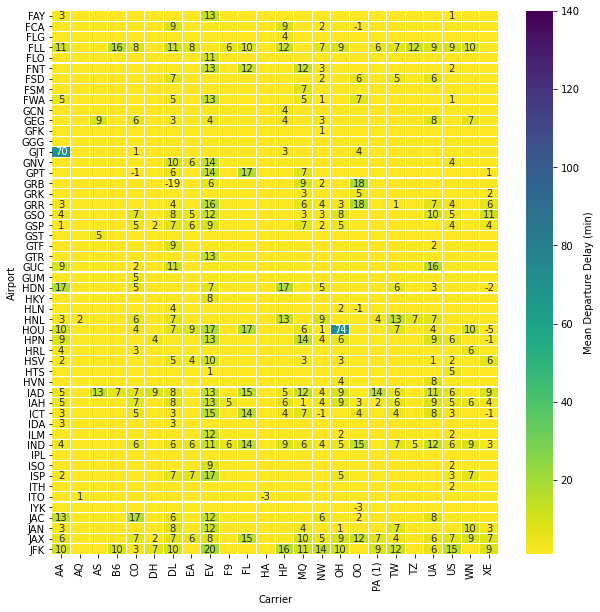

In [24]:
plt.figure(figsize=(10,10))
sb.heatmap(ddm_sliced[2], annot=labels_sliced[2], fmt='s', vmin=1, vmax=140, cmap='viridis_r', linewidth=0.1, 
           cbar_kws ={'label':'Mean Departure Delay (min)'})
plt.ylabel('Airport')
plt.xlabel('Carrier');

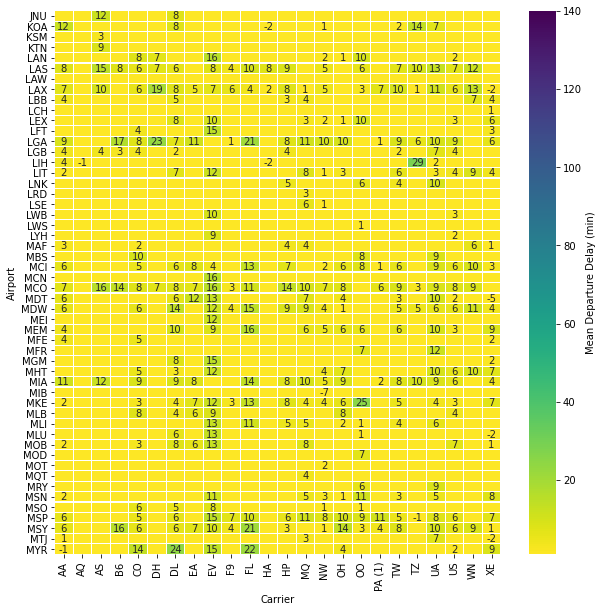

In [25]:
plt.figure(figsize=(10,10))
sb.heatmap(ddm_sliced[3], annot=labels_sliced[3], fmt='s', vmin=1, vmax=140, cmap='viridis_r', linewidth=0.1, 
           cbar_kws ={'label':'Mean Departure Delay (min)'})
plt.ylabel('Airport')
plt.xlabel('Carrier');

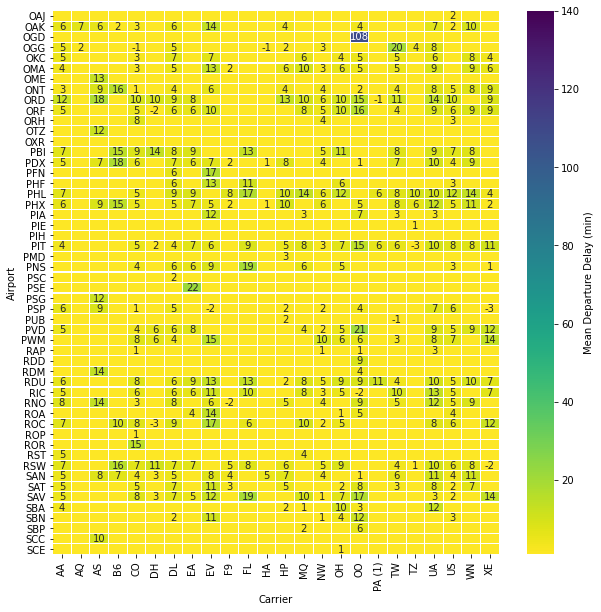

In [26]:
plt.figure(figsize=(10,10))
sb.heatmap(ddm_sliced[4], annot=labels_sliced[4], fmt='s', vmin=1, vmax=140, cmap='viridis_r', linewidth=0.1, 
           cbar_kws ={'label':'Mean Departure Delay (min)'})
plt.ylabel('Airport')
plt.xlabel('Carrier');

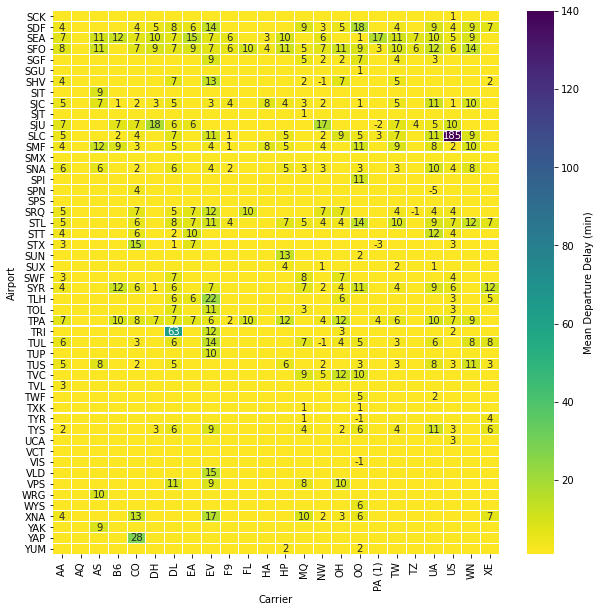

In [27]:
plt.figure(figsize=(10,10))
sb.heatmap(ddm_sliced[5], annot=labels_sliced[5], fmt='s', vmin=1, vmax=140, cmap='viridis_r', linewidth=0.1, 
           cbar_kws ={'label':'Mean Departure Delay (min)'})
plt.ylabel('Airport')
plt.xlabel('Carrier');

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

1. When we expand the chronological view of departure delays, we further strengthened the ability to conclude that chronologically there was tendancy to have increased number of flights with negative delays (depart earlier than scheduled). This might go against the flow of belief that increasing security checks at airports tend to result in more delays.
2. CKB airport ranked first in the top delays in the bivariate analysis section. Interestingly enough, the multivariate heatmap show that this top average delay occured by single air line (OH).

### Were there any interesting or surprising interactions between features?

When we started analyzing the data, we were mainly considering patterns of flight delays cronologically. However, in the course of analysis, we found the most interesting descriptive statistics for delay patterns were related to categorical variables such as the airports and the carriers.

## Summary of Findings

1. There are 7 Carriers **(DL, WN, US, AA, UA, NW, CO)** that operated more than ***1.5 million flights each***. We can call those the big players.  
2. It is seen that there are 11 airports **(ATL, ORD, DFW, LAX, PHX. DEN, IAH, DTW, STL, MSP, SFQ)** that have more than ***1 million flights each***.  
3. There is a ***strong positive relation between Departure and Arrival delays***.  
4. We observed interesting relation between the carrier operating volume and their departure delays. **DL** tend to be the jiant going down the slippery road, **WN** earn thumbs up for being a big player and having minimum delays, **UA** on the other hand may need consultation to strengthen its volume and minimize its delays.  
5. With this dataset, we can only attibute an airport to a departure delay. ***Arrival delays cannot be explained*** by the selected dataset due to the random selection of years as well as its cleaning. This is further statistically evident from the strong positive relation ship between Departure and Arrival delays.
6. The top operating airports **(ATL, ORD, DFW)** have ***spectacular operations*** to keep their departure delays less than 15 minutes.
7. When we expand the chronological view of departure delays, we further strengthened the ability to conclude that chronologically there was tendancy to have ***increased number of flights with negative delays (depart earlier than scheduled)***.
8. **CKB** airport ranked first in the ***top departure delays***. Interestingly enough, the multivariate heatmap show that this top average delay occured by single air line **(OH)**.